# Example of visualising the data 
## For reproducing the results in the paper

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os 
import warnings
warnings.filterwarnings('ignore')


from matplotlib import cm
from joypy import joyplot
from utils.data_utils import correct_col_type,gen_date_col,transform_category_to_counts,gen_summary
from utils.vis_utils import vis_day_counts_ridge_plot,save_fig,vis_personal_aligned_multiview_day_plot

In [74]:
%matplotlib inline

In [75]:
## Please change the path with the path of your dataset
DPATH = '../Dataset/'
SAVE_PATH = './figs/'

In [76]:
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [77]:
## Read all tables into data_dict and generate table summaries

files = os.listdir(DPATH)
data_dict = {}
summaries = {}
for f in files:
    if 'csv' not in f:
        continue
    print(f)
    fpth = os.path.join(DPATH,f)
    df = pd.read_csv(fpth)

    for col in df.columns:
        df[col] = correct_col_type(df,col)
    
    if 'date' in df.columns:
        df = df.rename(columns={'date':'timestamp'})
                
    fname = f.split('.')[0]
    data_dict[fname] = df
    
    summaries[fname] = gen_summary(df)

Labels.csv
Physiology.csv
Activity.csv
Sleep.csv
Demographics.csv


In [78]:
summaries['Sleep']

,Value Type,Value Number,Description
patient_id,ObjectDType,NaN,NaN
timestamp,ObjectDType,NaN,NaN
state,ObjectDType,NaN,NaN
heart_rate,Float64DType,NaN,NaN
respiratory_rate,Float64DType,NaN,NaN
snoring,BoolDType,NaN,NaN


In [79]:
## Set colour palette
ibm_colorblind = ['#648FFF', '#FE6100', '#DC267F', '#785EF0', '#FFB000','#48A9A6']
sns.set_palette(ibm_colorblind)

In [80]:
## Generate a date column for Labels table 
import pandas as pd

def gen_date_col(df, tcol):
    # Check if the column exists
    if tcol not in df.columns:
        raise KeyError(f"'{tcol}' column not found in DataFrame")

    # Ensure the column is converted to datetime, handling errors
    df[tcol] = pd.to_datetime(df[tcol], errors='coerce')
    
    # Check for conversion issues (e.g., NaT values)
    if df[tcol].isnull().any():
        print(f"Warning: {df[tcol].isnull().sum()} rows contain invalid datetime in the '{tcol}' column.")

    # Now you can safely use .dt accessor
    df['date'] = df[tcol].dt.date
    return df

# Use the function
lbl_df = gen_date_col(data_dict['Labels'], tcol='timestamp')

# Check value counts for 'type' column
print(lbl_df['type'].value_counts())

type
Blood pressure      305
Agitation           135
Pulse                95
Body water           68
Weight                4
Body temperature      1
Name: count, dtype: int64


In [81]:
## Generate a date column for Activity table 
act_df1 = gen_date_col(data_dict['Activity'],tcol='timestamp')
act_df1.location_name.value_counts()

location_name
Kitchen        227312
Hallway        193984
Lounge         180767
Bedroom        131133
Fridge Door    108803
Bathroom        82027
Front Door      58287
Back Door       48246
Name: count, dtype: int64

In [82]:
## Aggreate daily counts of acitivities in each location
act_df = transform_category_to_counts(act_df1,col='location_name',keys=['patient_id','date'])
act_df.head()

location_name,patient_id,date,Back Door,Bathroom,Bedroom,Fridge Door,Front Door,Hallway,Kitchen,Lounge
0,0697d,2019-06-28,14.0,7.0,24.0,23.0,28.0,40.0,106.0,80.0
1,0697d,2019-06-29,2.0,11.0,26.0,8.0,23.0,57.0,120.0,117.0
2,0697d,2019-06-30,4.0,14.0,53.0,NaN,8.0,57.0,119.0,103.0
3,099bc,2019-05-15,12.0,17.0,31.0,27.0,13.0,32.0,71.0,6.0
4,099bc,2019-05-16,14.0,42.0,85.0,22.0,6.0,50.0,104.0,9.0


In [83]:
## Calculate average person-day in the dataset
p_ct = act_df.groupby('date').size().to_frame('Number of Patients')
act_df.groupby('patient_id').size().mean()

48.607142857142854

Text(0, 0.5, 'Number of Paticipants')

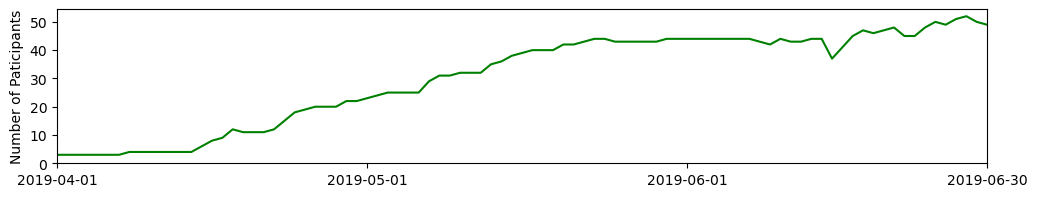

In [84]:
## Visualise number of paticipants with time
plt.figure(figsize=[12,2])
plt.plot(p_ct,color='g')
idx = [0,29,60,88]
plt.xticks(p_ct.index[idx],labels=p_ct.index[idx])

plt.xlim(p_ct.index[0],p_ct.index[-1])
plt.yticks(np.arange(0,60,10))
plt.ylabel('Number of Paticipants')

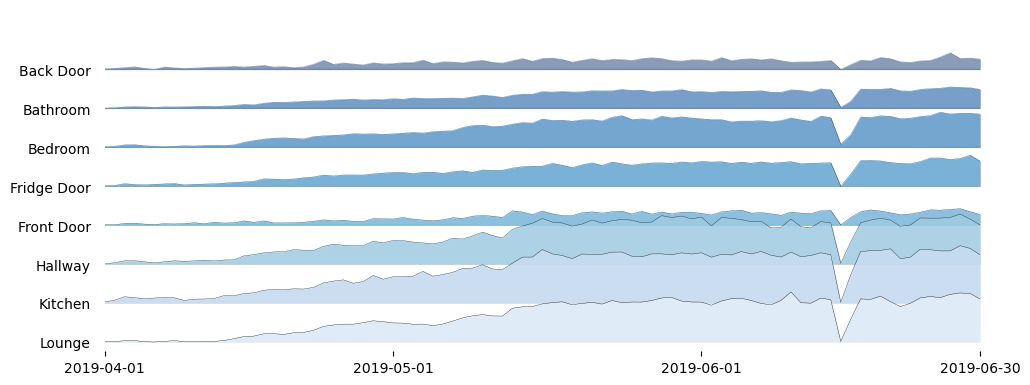

In [85]:
## Visualise location-activity with time

all_act = act_df.groupby('date').agg('sum')
vis_day_counts_ridge_plot(act_df,'location_name',title='',
                          fname='all_activity_ridgeplot.svg',save_path=SAVE_PATH,
                          xticks=([0,29,60,88],all_act.index[[0,29,60,-1]]))

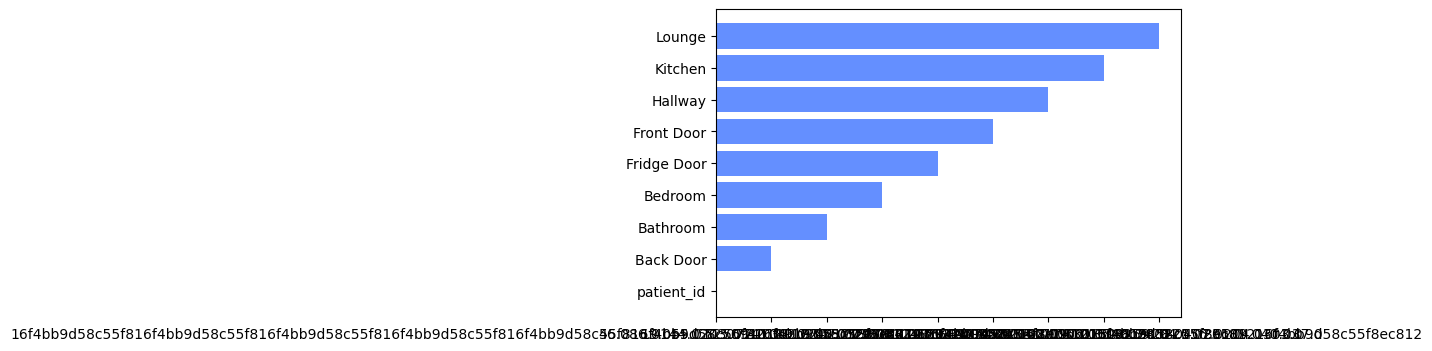

In [86]:
## Visualise total counts of each location

tmp = act_df.groupby('date').sum()
tmp = tmp.astype(str).head(10)
plt.figure(figsize=[6,4])
bars = plt.barh(width=tmp.sum(axis=0),y=tmp.columns)

In [87]:
tmp.sum(axis=0)

location_name
patient_id     16f4bb9d58c55f816f4bb9d58c55f816f4bb9d58c55f81...
Back Door           46.086.0144.0203.091.03.0193.0127.078.0107.0
Bathroom         19.055.0115.0141.0117.075.0121.0114.0127.0149.0
Bedroom            52.077.0189.0205.0122.084.062.084.0120.0103.0
Fridge Door     42.062.0202.0138.0112.0154.0180.0216.0106.0150.0
Front Door         42.032.0147.0159.090.057.0122.097.0132.0191.0
Hallway        29.0112.0253.0271.0182.0114.0185.0259.0221.0255.0
Kitchen        103.0222.0485.0417.0330.0388.0428.0407.0204.03...
Lounge                24.040.0106.0118.028.04.056.0109.040.037.0
dtype: object

In [88]:
## Aggregate Physiology table
physio_df = gen_date_col(data_dict['Physiology'],tcol='timestamp')
phys = physio_df.groupby(['patient_id','date','device_type']).agg('max')
phys.drop(phys.loc[phys.sum(axis=1)==0].index,axis=0,inplace=True)
phys.reset_index(inplace=True)
phys.head()

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'float'

In [ ]:
## Visualize Physiology measurements align with labels for an individual participant
pgrps = {'pgrp1': ['Systolic blood pressure','Diastolic blood pressure', 'Heart rate'], 
            'pgrp2' : ['O/E - muscle mass', 'Total body water', 'Body weight'],
            'pgrp3' : [ 'Skin temperature','Body temperature']}
x_idx = phys.groupby('date').mean().index

vis_personal_aligned_multiview_day_plot(sleep_df=None,act_df=None,phys_df=phys,pgrps=pgrps,pid='c55f8',save_path=SAVE_PATH,
                                        labels_df=lbl_df,ftype='pdf',xticks=(x_idx[[0,30,61,90]],x_idx[[0,30,61,90]]))